|Model |RMSE | Rank|
|---|---|--- |
|LSTM| 0.98340| - 
|LightGBM (optuna Tuning)|0.908 |Top 20%
|XGBoost + Additional Features | 0.88192| Top 2%|

# Predict Sale
## 0. References

* Feature Engineering: 

https://www.kaggle.com/dlarionov/feature-engineering-xgboost

* 딥러닝으로 걷는 시계열 예측- 윤영선 지음 : LSTM Model 

http://www.yes24.com/Product/Goods/89019624

* LightGBM + optuna :

https://www.kaggle.com/dhiiyaur/predict-future-sales-lgbm-hyperparameter-optuna

* XGBoost + Optuna :

https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407



## 1. Data Preprocessing
  * Read Data
  * Remove outlier
  * item category, shop name label encoding
  * Add Monthly Features + Lag feature
    * 매월 아이템 수(평균)
    * 매월 아이템별 판매량
    * 매월 가게별 판매량
    * 매월 아이템 카테고리별 판매량
    * 매월 가게 - 아이템 카테고리별 판매량
    * 매월 블록, 가게별 판매량
    * 매월 가게별 하위 카테고리 판매량
    * 매월 도시 판매량
    * 매월 아이템 가격
  
## 2. Train

* LSTM
* LightGBM
* LightGBM KFold
* XGBoost


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle
import time
from itertools import product

import optuna
import lightgbm as lgb
from lightgbm import plot_importance
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

pd.set_option('display.float_format', lambda x: '%.3f'%x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
# --------------------  Read Data ----------------------------

path = "../input/competitive-data-science-predict-future-sales/"

# train 
df_sales       = pd.read_csv(path+'sales_train.csv')
df_items       = pd.read_csv(path+'items.csv')
df_item_cat    = pd.read_csv(path+'item_categories.csv')
df_shops       = pd.read_csv(path+"shops.csv")

# test
df_test        = pd.read_csv(path+'test.csv')
df_sample_subs = pd.read_csv(path+'sample_submission.csv')

In [4]:
df_sales = df_sales[df_sales.item_price<100000]
df_sales = df_sales[df_sales.item_cnt_day<1000]

df_sales = df_sales[df_sales.item_cnt_day>0]
df_sales = df_sales.reset_index(drop=True)

df_sales.loc[df_sales.item_cnt_day<0, 'item_cnt_day'] = 0


df_sales.loc[df_sales.shop_id==0, 'shop_id']  = 57
df_sales.loc[df_sales.shop_id==1, 'shop_id']  = 58
df_sales.loc[df_sales.shop_id==11, 'shop_id'] = 10

df_shops.loc[df_shops.shop_name== 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
df_shops['shop_city'] = df_shops['shop_name'].str.split(" ").map(lambda x:x[0])
df_shops['shop_cat']  = df_shops['shop_name'].str.split(" ").map(lambda x:x[1])

df_shops['shop_city'] = LabelEncoder().fit_transform(df_shops['shop_city'])
df_shops['shop_cat']  = LabelEncoder().fit_transform(df_shops['shop_cat'])
df_shops.drop(['shop_name'], axis=1, inplace=True)
df_shops.head()

df_items = pd.merge(df_items, df_item_cat, on="item_category_id")

# split item categories into several parts

df_items['item_sub_cat_1'] = np.select(
    [df_items.item_category_id.isin(range(0,8)),
    df_items.item_category_id.isin(range(10,18)),
    df_items.item_category_id.isin(range(18,32)),
    df_items.item_category_id.isin(range(32,37)),
    df_items.item_category_id.isin(range(37,42)),
    df_items.item_category_id.isin(range(42,55)),
    df_items.item_category_id.isin(range(55,61)),
    df_items.item_category_id.isin(range(61,73)),
    df_items.item_category_id.isin(range(73,79)),
    df_items.item_category_id.isin([8,80]),
    df_items.item_category_id==83, 
    df_items.item_category_id==9,
    df_items.item_category_id==79,  
    df_items.item_category_id.isin([81,82])],

    ['accessories','consoles','games','payment_cards','Cinema','books','music',
     'gifts','programs','tickets','batteries','delivery','office','discs'])

df_items['item_sub_cat_1'] = LabelEncoder().fit_transform(df_items['item_sub_cat_1'])
df_items.drop(['item_name','item_category_name'], axis=1, inplace= True)

df_all = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = df_sales[df_sales.date_block_num==i]
    df_all.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
df_all = pd.DataFrame(np.vstack(df_all), columns=cols)
df_all['date_block_num'] = df_all['date_block_num'].astype(np.int8)
df_all['shop_id'] = df_all['shop_id'].astype(np.int8)
df_all['item_id'] = df_all['item_id'].astype(np.int16)
df_all.sort_values(cols,inplace=True)

df_test.drop(['ID'], axis=1, inplace=True)
df_test['date_block_num'] = 34
df_test['date_block_num'] = df_test['date_block_num']
df_test['shop_id'] = df_test['shop_id']
df_test['item_id'] = df_test['item_id']

df_all = pd.concat([df_all, df_test], ignore_index=True, sort=False, keys=cols)
df_all = pd.merge(df_all, df_shops, on=['shop_id'], how='left')
df_all = pd.merge(df_all, df_items, on=['item_id'], how='left')
df_all.fillna(0, inplace=True)


df_all.date_block_num    = df_all.date_block_num.astype(np.int8)
df_all.shop_id           = df_all.shop_id.astype(np.int8)
df_all.item_id           = df_all.item_id.astype(np.int16)
df_all.shop_city         = df_all.shop_city.astype(np.int8)
df_all.shop_cat          = df_all.shop_cat.astype(np.int8)
df_all.item_category_id  = df_all.item_category_id.astype(np.int8)
df_all.item_sub_cat_1    = df_all.item_sub_cat_1.astype(np.int8)

In [5]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] +=1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id', 'item_id'], how='left')
    return df

def fill_na_test(df):
    for col in df.columns:
        if ('_lag' in col) & (df[col].isnull().any()):
            print(col)
            if 'month' in col:
                df[col].fillna(0, inplace=True)
    return df
            

In [6]:
ts = time.time()


# 매월 가게, 아이템별 판매량

temp = df_sales.groupby(['shop_id','item_id','date_block_num']).agg(item_cnt_month=('item_cnt_day',sum))
temp.columns = ['item_cnt_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=cols, how='left')
df_all['item_cnt_month'] = (df_all['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))
df_all = lag_feature(df_all, [1, 2, 3,4], 'item_cnt_month')


# 매월 아이템별 판매량
temp = df_all.groupby(['date_block_num']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num'], how='left')
df_all = lag_feature(df_all, [1, 2, 3], 'avg_month')
df_all.drop(['avg_month'], axis=1, inplace= True)

# 매월 아이템별 판매량
temp = df_all.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_item_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num', 'item_id'], how='left')
df_all = lag_feature(df_all, [1, 2, 3], 'avg_item_month')
df_all.drop(['avg_item_month'], axis=1, inplace= True)

# 매월 가게별 판매량
temp = df_all.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shop_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num', 'shop_id'], how='left')
df_all = lag_feature(df_all, [1, 2], 'avg_shop_month')
df_all.drop(['avg_shop_month'], axis=1, inplace= True)

# 매월 아이템카테고리별 판매량
temp = df_all.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_item_cat_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num', 'item_category_id'], how='left')
df_all = lag_feature(df_all, [1,2,3], 'avg_item_cat_month')
df_all.drop(['avg_item_cat_month'], axis=1, inplace= True)

# 매월 가게 - 아이템 카테고리별 판매량
temp = df_all.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shops_itemcat_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
df_all = lag_feature(df_all, [1,2], 'avg_shops_itemcat_month')
df_all.drop(['avg_shops_itemcat_month'], axis=1, inplace= True)

# 매월 블록, 가게별 판매량
temp = df_all.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shops_item_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num', 'shop_id', 'item_id'], how='left')
df_all = lag_feature(df_all, [1,2], 'avg_shops_item_month')
df_all.drop(['avg_shops_item_month'], axis=1, inplace= True)

# 매월 가게별 하위 카테고리 판매량
temp = df_all.groupby(['date_block_num', 'shop_id', 'item_sub_cat_1']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shops_item_sub_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num', 'shop_id', 'item_sub_cat_1'], how='left')
df_all = lag_feature(df_all, [1,2], 'avg_shops_item_sub_month')
df_all.drop(['avg_shops_item_sub_month'], axis=1, inplace= True)

# 매월 도시 판매량
temp = df_all.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month' : ['mean']})
temp.columns = ['avg_shopscity_month']
temp.reset_index(inplace=True)
df_all = pd.merge(df_all, temp, on=['date_block_num', 'shop_city'], how='left')
df_all = lag_feature(df_all, [1,2], 'avg_shopscity_month')
df_all.drop(['avg_shopscity_month'], axis=1, inplace= True)

df_all

print('Use time:', time.time() - ts)


Use time: 242.22507691383362


In [7]:
# 월, 일, 년도 추가
df_all['month'] = df_all['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
df_all['days'] = df_all['month'].map(days)
df_all['years'] = np.select(
    [df_all.date_block_num.isin(range(0,12)),
     df_all.date_block_num.isin(range(12,25)),
     df_all.date_block_num.isin(range(25,35))],
    ['13','14','15'])

df_all['month'] = df_all['month'] + 1  # fix month

# 타입변경

df_all['days']  = df_all['days'].astype(np.int8)
df_all['month'] = df_all['month'].astype(np.int8)
df_all['years'] = df_all['years'].astype(np.int8)


# 판매를 시작한 첫 월

df_all['item_shop_first_sale'] = \
df_all['date_block_num'] - df_all.groupby(['item_id','shop_id'])['date_block_num'].transform('min')

df_all['item_first_sale'] = \
df_all['date_block_num'] - df_all.groupby('item_id')['date_block_num'].transform('min')

In [8]:
def merge_to_All(temp, on):
    global df_all
    temp = temp.astype(np.float16)
    temp.reset_index(inplace=True)
    df_all = pd.merge(df_all, temp, on=on, how='left')
    return df_all


temp = df_sales.groupby(['date_block_num','item_id']).agg(item_price_sum_di=('item_price','sum'))
temp.index.set_levels(temp.index.levels[0] + 1, 0, inplace=True)
df_all = merge_to_All(temp, ['date_block_num','item_id'])

temp = df_sales.groupby(['date_block_num','item_id']).agg(item_price_mean_di=('item_price','mean'))
temp.index.set_levels(temp.index.levels[0] + 1, 0, inplace=True)
df_all = merge_to_All(temp, ['date_block_num','item_id'])

temp = df_sales.groupby(['date_block_num','shop_id','item_id']).agg(item_price_mean_di=('item_price','mean'))
temp.index.set_levels(temp.index.levels[0] + 1, 0, inplace=True)
df_all = merge_to_All(temp, ['date_block_num','shop_id','item_id'])


# 1
temp = df_sales.groupby(['shop_id','item_id']).agg(item_price_mean_is=('item_price','sum'))
temp = temp.apply(np.log)
df_all = merge_to_All(temp, ['shop_id','item_id'])

# 1-1
temp = df_sales.groupby(['shop_id','item_id']).agg(item_price_mean_is_mean=('item_price','mean'))
df_all = merge_to_All(temp, ['shop_id','item_id'])

# 2
temp = temp.apply(np.sqrt)
temp.columns = ['item_price_mean_is_sq']
df_all = merge_to_All(temp, ['shop_id','item_id'])

# 3
temp = df_sales.groupby(['shop_id','item_id']).agg(item_price_max_is =('item_price', 'max'))
temp = temp.apply(np.log)
df_all = merge_to_All(temp, ['shop_id','item_id'])

# 4
#temp = df_sales.groupby(['shop_id','item_id']).agg(item_price_min_is =('item_price', 'min'))
#df_all = merge_to_All(temp, ['shop_id','item_id'])

# 5
temp = df_sales.groupby(['item_id']).agg(item_price_mean_i=('item_price','mean'))
df_all = merge_to_All(temp, ['item_id'])

# 6
#temp = 1/temp
#temp.columns = ['item_price_mean_id_sq']
#df_all = merge_to_All(temp, ['item_id'])

# 7
temp = df_sales.groupby(['item_id']).agg(item_price_max_i =('item_price', 'max'))
temp = temp.apply(np.log)
df_all = merge_to_All(temp, ['item_id'])

# 8
#temp = df_sales.groupby(['item_id']).agg(item_price_min_i =('item_price', 'min'))
#df_all = merge_to_All(temp, ['item_id'])

# 9
temp = df_sales.groupby(['shop_id']).agg(item_price_mean_s=('item_price','mean'))
df_all = merge_to_All(temp, ['shop_id'])

del temp

gc.collect()

0

In [9]:
# 메모리 절약
df_all = fill_na_test(df_all)
df_all.to_pickle('dataset.pkl')

del df_all
del df_sales
del df_items
del df_item_cat
del df_shops

gc.collect()


item_cnt_month_lag_1
item_cnt_month_lag_2
item_cnt_month_lag_3
item_cnt_month_lag_4
avg_month_lag_1
avg_month_lag_2
avg_month_lag_3
avg_item_month_lag_1
avg_item_month_lag_2
avg_item_month_lag_3
avg_shop_month_lag_1
avg_shop_month_lag_2
avg_item_cat_month_lag_1
avg_item_cat_month_lag_2
avg_item_cat_month_lag_3
avg_shops_itemcat_month_lag_1
avg_shops_itemcat_month_lag_2
avg_shops_item_month_lag_1
avg_shops_item_month_lag_2
avg_shops_item_sub_month_lag_1
avg_shops_item_sub_month_lag_2
avg_shopscity_month_lag_1
avg_shopscity_month_lag_2


0

In [10]:
import pandas as pd
data = pd.read_pickle('dataset.pkl')

# LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping

In [ ]:
X_train = data[data.date_block_num < 34].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 34]['item_cnt_month']

X_test  = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
model = Sequential()
model.add(LSTM(10, input_shape=(X_train.shape[1],1)))
model.add(Dense(1))

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.compile(loss='mean_squared_error', optimizer='adam')


model.summary()




In [ ]:
model.fit(X_train, Y_train, epochs=20, batch_size=256, callbacks=[early_stop], verbose=0
          
Y_test = model.predict(X_test)
Y_test2 = Y_test.reshape(Y_test.shape[0])
submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": Y_test2
})
submission.head(10)

submission.to_csv('submission_lstm.csv', index=False)
          

# LightGBM

In [11]:
from sklearn.preprocessing import MinMaxScaler

X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']

X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']

X_test  = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)


del data
gc.collect()

0

In [12]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)


In [13]:
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval  = lgb.Dataset(X_valid, Y_valid, reference=lgb_train)

In [14]:
# Small Bagging Fraction
# Small numleaves (Best)
# Small featurefraction
# Large Lambda1, Lambda2

# Use small early stopping
# Kfold
    
def objective(trial):
    
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 3, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 3, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 3, 10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 0.5),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 4),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    model = lgb.train(param, 
                      lgb_train,
                      valid_sets=[lgb_train,lgb_eval],
                      early_stopping_rounds=5, #10,
                      verbose_eval=1)
    
    y_pred = model.predict(X_valid)
    accuracy = rmsle(Y_valid, y_pred)

    return accuracy

In [15]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[1]	training's rmse: 1.18174	valid_1's rmse: 1.10508
Training until validation scores don't improve for 5 rounds
[2]	training's rmse: 1.14298	valid_1's rmse: 1.07725
[3]	training's rmse: 1.10957	valid_1's rmse: 1.05296
[4]	training's rmse: 1.08036	valid_1's rmse: 1.03327
[5]	training's rmse: 1.05842	valid_1's rmse: 1.01588
[6]	training's rmse: 1.03673	valid_1's rmse: 1.0028
[7]	training's rmse: 1.02111	valid_1's rmse: 0.991631
[8]	training's rmse: 1.00427	valid_1's rmse: 0.981468
[9]	training's rmse: 0.990297	valid_1's rmse: 0.97336
[10]	training's rmse: 0.977802	valid_1's rmse: 0.964966
[11]	training's rmse: 0.967591	valid_1's rmse: 0.958833
[12]	training's rmse: 0.960223	valid_1's rmse: 0.954633
[13]	training's rmse: 0.952923	valid_1's rmse: 0.948822
[14]	training's rmse: 0.947243	valid_1's rmse: 0.945416
[15]	training's rmse: 0.942128	valid_1's rmse: 0.94243
[16]	training's rmse: 0.934825	valid_1's rmse: 0.939968
[17]	training's rmse: 0.929014	valid_1's rmse: 0.93823
[18]	training's

[I 2020-07-29 06:10:09,091] Finished trial#0 with value: 0.8906101068026286 with parameters: {'lambda_l1': 3.947401576151497, 'lambda_l2': 9.935242703583734, 'num_leaves': 6, 'feature_fraction': 0.7434169583116786, 'bagging_fraction': 0.3700871398800115, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial#0 with value: 0.8906101068026286.


[1]	training's rmse: 1.18498	valid_1's rmse: 1.10371
Training until validation scores don't improve for 5 rounds
[2]	training's rmse: 1.14551	valid_1's rmse: 1.07662
[3]	training's rmse: 1.10854	valid_1's rmse: 1.05387
[4]	training's rmse: 1.07637	valid_1's rmse: 1.03296
[5]	training's rmse: 1.05328	valid_1's rmse: 1.01535
[6]	training's rmse: 1.02949	valid_1's rmse: 1.00152
[7]	training's rmse: 1.0123	valid_1's rmse: 0.988002
[8]	training's rmse: 0.992435	valid_1's rmse: 0.977594
[9]	training's rmse: 0.976382	valid_1's rmse: 0.967413
[10]	training's rmse: 0.964126	valid_1's rmse: 0.96151
[11]	training's rmse: 0.955166	valid_1's rmse: 0.955528
[12]	training's rmse: 0.947675	valid_1's rmse: 0.95023
[13]	training's rmse: 0.940327	valid_1's rmse: 0.944785
[14]	training's rmse: 0.934702	valid_1's rmse: 0.941023
[15]	training's rmse: 0.929529	valid_1's rmse: 0.937985
[16]	training's rmse: 0.922051	valid_1's rmse: 0.935497
[17]	training's rmse: 0.912546	valid_1's rmse: 0.933496
[18]	training

[I 2020-07-29 06:10:55,499] Finished trial#1 with value: 0.8795783477784976 with parameters: {'lambda_l1': 6.323629736870372, 'lambda_l2': 9.239006536127274, 'num_leaves': 8, 'feature_fraction': 0.4862200092962423, 'bagging_fraction': 0.29430516677790863, 'bagging_freq': 2, 'min_child_samples': 80}. Best is trial#1 with value: 0.8795783477784976.


[1]	training's rmse: 1.18178	valid_1's rmse: 1.10511
Training until validation scores don't improve for 5 rounds
[2]	training's rmse: 1.14299	valid_1's rmse: 1.07772
[3]	training's rmse: 1.10933	valid_1's rmse: 1.05394
[4]	training's rmse: 1.08086	valid_1's rmse: 1.03574
[5]	training's rmse: 1.05843	valid_1's rmse: 1.01816
[6]	training's rmse: 1.0367	valid_1's rmse: 1.00412
[7]	training's rmse: 1.02021	valid_1's rmse: 0.9914
[8]	training's rmse: 1.00381	valid_1's rmse: 0.981421
[9]	training's rmse: 0.98983	valid_1's rmse: 0.972919
[10]	training's rmse: 0.977449	valid_1's rmse: 0.96594
[11]	training's rmse: 0.967724	valid_1's rmse: 0.96051
[12]	training's rmse: 0.958432	valid_1's rmse: 0.956239
[13]	training's rmse: 0.951113	valid_1's rmse: 0.9506
[14]	training's rmse: 0.945175	valid_1's rmse: 0.947607
[15]	training's rmse: 0.940227	valid_1's rmse: 0.944603
[16]	training's rmse: 0.933379	valid_1's rmse: 0.940999
[17]	training's rmse: 0.926654	valid_1's rmse: 0.938027
[18]	training's rms

[I 2020-07-29 06:11:47,438] Finished trial#2 with value: 0.8855041241360749 with parameters: {'lambda_l1': 8.50563187744371, 'lambda_l2': 6.919658963680387, 'num_leaves': 6, 'feature_fraction': 0.7628873598685524, 'bagging_fraction': 0.3852689145872835, 'bagging_freq': 2, 'min_child_samples': 41}. Best is trial#1 with value: 0.8795783477784976.


[1]	training's rmse: 1.18975	valid_1's rmse: 1.10965
Training until validation scores don't improve for 5 rounds
[2]	training's rmse: 1.15817	valid_1's rmse: 1.08629
[3]	training's rmse: 1.12793	valid_1's rmse: 1.06502
[4]	training's rmse: 1.10236	valid_1's rmse: 1.04692
[5]	training's rmse: 1.08302	valid_1's rmse: 1.03443
[6]	training's rmse: 1.06663	valid_1's rmse: 1.02358
[7]	training's rmse: 1.05289	valid_1's rmse: 1.01444
[8]	training's rmse: 1.03919	valid_1's rmse: 1.00422
[9]	training's rmse: 1.028	valid_1's rmse: 0.995752
[10]	training's rmse: 1.01248	valid_1's rmse: 0.987865
[11]	training's rmse: 1.00459	valid_1's rmse: 0.982972
[12]	training's rmse: 0.997343	valid_1's rmse: 0.978583
[13]	training's rmse: 0.991376	valid_1's rmse: 0.975032
[14]	training's rmse: 0.986301	valid_1's rmse: 0.97253
[15]	training's rmse: 0.980285	valid_1's rmse: 0.967365
[16]	training's rmse: 0.976234	valid_1's rmse: 0.964609
[17]	training's rmse: 0.972623	valid_1's rmse: 0.962594
[18]	training's rms

[I 2020-07-29 06:12:13,167] Finished trial#3 with value: 0.9103645413604663 with parameters: {'lambda_l1': 9.376266860637289, 'lambda_l2': 6.752897985041947, 'num_leaves': 5, 'feature_fraction': 0.23477238712094833, 'bagging_fraction': 0.11045677440877717, 'bagging_freq': 2, 'min_child_samples': 67}. Best is trial#1 with value: 0.8795783477784976.


[1]	training's rmse: 1.19555	valid_1's rmse: 1.11561
Training until validation scores don't improve for 5 rounds
[2]	training's rmse: 1.16759	valid_1's rmse: 1.09702
[3]	training's rmse: 1.1433	valid_1's rmse: 1.07983
[4]	training's rmse: 1.12203	valid_1's rmse: 1.06552
[5]	training's rmse: 1.10288	valid_1's rmse: 1.05211
[6]	training's rmse: 1.08748	valid_1's rmse: 1.04217
[7]	training's rmse: 1.07324	valid_1's rmse: 1.0327
[8]	training's rmse: 1.06022	valid_1's rmse: 1.02565
[9]	training's rmse: 1.05025	valid_1's rmse: 1.01953
[10]	training's rmse: 1.04036	valid_1's rmse: 1.01324
[11]	training's rmse: 1.03048	valid_1's rmse: 1.00963
[12]	training's rmse: 1.02285	valid_1's rmse: 1.00596
[13]	training's rmse: 1.0164	valid_1's rmse: 1.00314
[14]	training's rmse: 1.00949	valid_1's rmse: 1.00138
[15]	training's rmse: 1.00378	valid_1's rmse: 0.998186
[16]	training's rmse: 0.994918	valid_1's rmse: 0.994311
[17]	training's rmse: 0.989571	valid_1's rmse: 0.99219
[18]	training's rmse: 0.985337

[I 2020-07-29 06:12:56,337] Finished trial#4 with value: 0.9283481488852957 with parameters: {'lambda_l1': 3.4530163439049835, 'lambda_l2': 3.953822529232896, 'num_leaves': 3, 'feature_fraction': 0.8397284631719317, 'bagging_fraction': 0.23362274092696042, 'bagging_freq': 1, 'min_child_samples': 52}. Best is trial#1 with value: 0.8795783477784976.


Number of finished trials: 5
Best trial: {'lambda_l1': 6.323629736870372, 'lambda_l2': 9.239006536127274, 'num_leaves': 8, 'feature_fraction': 0.4862200092962423, 'bagging_fraction': 0.29430516677790863, 'bagging_freq': 2, 'min_child_samples': 80}


In [16]:
best_params = study.best_trial.params
print(f'Best trial parameters\n{best_params}')

del study
gc.collect()

Best trial parameters
{'lambda_l1': 6.323629736870372, 'lambda_l2': 9.239006536127274, 'num_leaves': 8, 'feature_fraction': 0.4862200092962423, 'bagging_fraction': 0.29430516677790863, 'bagging_freq': 2, 'min_child_samples': 80}


20

In [17]:
# add some fix params

x = {"objective": "regression",
     "metric"   : "rmse",
     "verbosity": -1,
     "boosting_type": "gbdt"}

best_params.update(x)
best_params

{'lambda_l1': 6.323629736870372,
 'lambda_l2': 9.239006536127274,
 'num_leaves': 8,
 'feature_fraction': 0.4862200092962423,
 'bagging_fraction': 0.29430516677790863,
 'bagging_freq': 2,
 'min_child_samples': 80,
 'objective': 'regression',
 'metric': 'rmse',
 'verbosity': -1,
 'boosting_type': 'gbdt'}

In [18]:
evals_result = {} 

model = lgb.train(best_params,
                  lgb_train,
                  valid_sets=[lgb_train,lgb_eval],
                  evals_result=evals_result,
                  early_stopping_rounds=30, # 20
                  verbose_eval=1,

                 )

[1]	training's rmse: 1.18498	valid_1's rmse: 1.10371
Training until validation scores don't improve for 30 rounds
[2]	training's rmse: 1.14551	valid_1's rmse: 1.07662
[3]	training's rmse: 1.10854	valid_1's rmse: 1.05387
[4]	training's rmse: 1.07637	valid_1's rmse: 1.03296
[5]	training's rmse: 1.05328	valid_1's rmse: 1.01535
[6]	training's rmse: 1.02949	valid_1's rmse: 1.00152
[7]	training's rmse: 1.0123	valid_1's rmse: 0.988002
[8]	training's rmse: 0.992435	valid_1's rmse: 0.977594
[9]	training's rmse: 0.976382	valid_1's rmse: 0.967413
[10]	training's rmse: 0.964126	valid_1's rmse: 0.96151
[11]	training's rmse: 0.955166	valid_1's rmse: 0.955528
[12]	training's rmse: 0.947675	valid_1's rmse: 0.95023
[13]	training's rmse: 0.940327	valid_1's rmse: 0.944785
[14]	training's rmse: 0.934702	valid_1's rmse: 0.941023
[15]	training's rmse: 0.929529	valid_1's rmse: 0.937985
[16]	training's rmse: 0.922051	valid_1's rmse: 0.935497
[17]	training's rmse: 0.912546	valid_1's rmse: 0.933496
[18]	trainin

In [19]:
y_pred = model.predict(X_valid)
rmsle(Y_valid, y_pred)

0.8795783477784976

feature importans


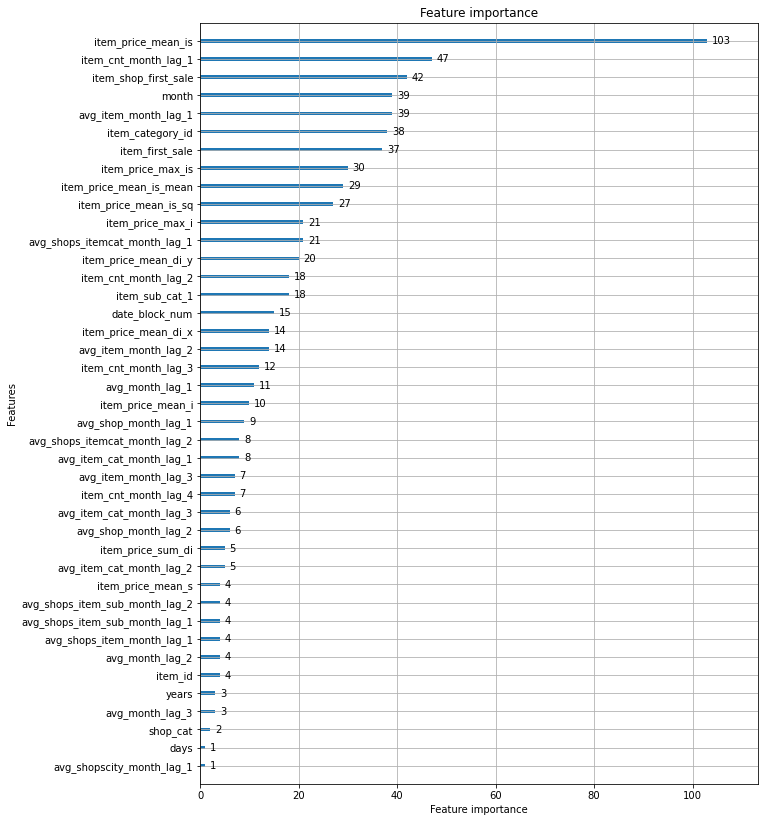

In [20]:
print('feature importans')
plot_features(model, (10,14))

Plot metrics recorded during training...


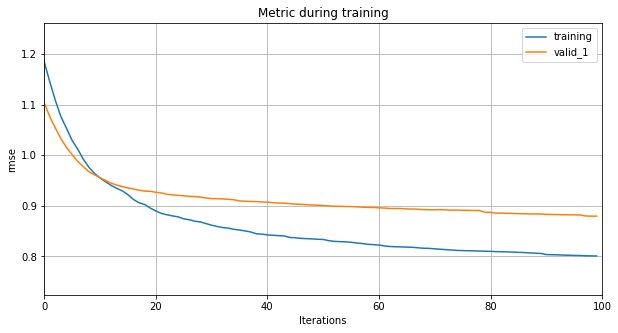

In [21]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, figsize=(10, 5))

In [22]:
Y_test = model.predict(X_test)

In [23]:
submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": Y_test
})

submission.to_csv('submission.csv', index=False)

In [24]:
# Clip Version
Y_test = Y_test.clip(0,20)

submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": Y_test
})

submission.to_csv('submission_with_clip.csv', index=False)

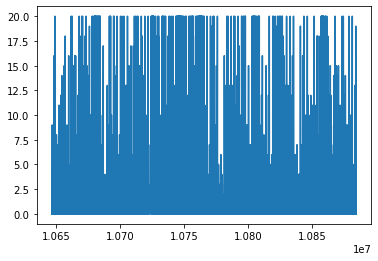

In [26]:
plt.plot(Y_test)

# LightGBM Kfold

In [ ]:
from sklearn.model_selection import KFold
Y_test /=6

In [ ]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 511)

X_train = data[data.date_block_num < 34].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 34]['item_cnt_month']

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train)) :
    
    train_X, train_y = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
    valid_X, valid_y = X_train.iloc[val_idx], Y_train.iloc[val_idx] 
    
    params = best_params

    train_ds = lgb.Dataset(train_X, label=train_y) 
    valid_ds = lgb.Dataset(valid_X, label=valid_y) 
    
    model = lgb.train(params, train_ds, 100, valid_ds, verbose_eval=1, early_stopping_rounds=10) 
    Y_test += model.predict(X_test) / (folds.n_splits+1)

In [ ]:
# Clip Version
Y_test = Y_test.clip(0,20)

submission = pd.DataFrame({
    "ID": df_test.index, 
    "item_cnt_month": Y_test
})

submission.to_csv('submission_with_clip.csv', index=False)

In [ ]:
plt.plot(Y_train)
plt.plot(Y_test)

# XGBoost

In [15]:
import pandas as pd
data = pd.read_pickle('dataset.pkl')


In [16]:
# XGB Memoery 부족. 일부 Feature만 선택

data = data[['date_block_num', 'shop_id', 'item_id', 'shop_city', 'shop_cat',
       'item_category_id', 'item_sub_cat_1', 'item_cnt_month',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_4', 'avg_month_lag_1', 'avg_month_lag_2',
       'avg_month_lag_3', 'avg_item_month_lag_1', 'avg_item_month_lag_2',
       'avg_item_month_lag_3', 'avg_shop_month_lag_1', 'avg_shop_month_lag_2',
       'avg_item_cat_month_lag_1', 'avg_item_cat_month_lag_2',
       'avg_item_cat_month_lag_3', 'avg_shops_itemcat_month_lag_1',
       'avg_shops_itemcat_month_lag_2', 'avg_shops_item_month_lag_1',
       'avg_shops_item_month_lag_2', 'avg_shops_item_sub_month_lag_1',
       'avg_shops_item_sub_month_lag_2', 'avg_shopscity_month_lag_1',
       'avg_shopscity_month_lag_2', 'month', 'days', 
       'item_shop_first_sale', 'item_first_sale', 'item_price_sum_di',
       'item_price_mean_di_x', 'item_price_mean_di_y']]

Index(['date_block_num', 'shop_id', 'item_id', 'shop_city', 'shop_cat',
       'item_category_id', 'item_sub_cat_1', 'item_cnt_month',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_4', 'avg_month_lag_1', 'avg_month_lag_2',
       'avg_month_lag_3', 'avg_item_month_lag_1', 'avg_item_month_lag_2',
       'avg_item_month_lag_3', 'avg_shop_month_lag_1', 'avg_shop_month_lag_2',
       'avg_item_cat_month_lag_1', 'avg_item_cat_month_lag_2',
       'avg_item_cat_month_lag_3', 'avg_shops_itemcat_month_lag_1',
       'avg_shops_itemcat_month_lag_2', 'avg_shops_item_month_lag_1',
       'avg_shops_item_month_lag_2', 'avg_shops_item_sub_month_lag_1',
       'avg_shops_item_sub_month_lag_2', 'avg_shopscity_month_lag_1',
       'avg_shopscity_month_lag_2', 'month', 'days', 'years',
       'item_shop_first_sale', 'item_first_sale', 'item_price_sum_di',
       'item_price_mean_di_x', 'item_price_mean_di_y'],
      dtype='object')

In [2]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']


X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']

X_test  = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

del data

In [3]:
import gc
gc.collect()

20

In [4]:
import time
from xgboost import XGBRegressor

ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
     #tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[05:13:30] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.18867	validation_1-rmse:1.12726
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:1.17038	validation_1-rmse:1.10503
[2]	validation_0-rmse:1.16164	validation_1-rmse:1.09236
[3]	validation_0-rmse:1.14883	validation_1-rmse:1.07995
[4]	validation_0-rmse:1.12441	validation_1-rmse:1.06270
[5]	validation_0-rmse:1.10923	validation_1-rmse:1.05068
[6]	validation_0-rmse:1.10030	validation_1-rmse:1.04104
[7]	validation_0-rmse:1.09261	validation_1-rmse:1.03425
[8]	validation_0-rmse:1.08167	validation_1-rmse:1.02320
[9]	validation_0-rmse:1.07245	validation_1-rmse:1.01573
[10]	validation_0-rmse:1.06570	validation_1-rmse:1.01226
[11]	va

1835.5754585266113

In [5]:
del X_train
del X_valid
del Y_test
del Y_valid

gc.collect()


NameError: name 'Y_test' is not defined

In [9]:
Y_test = model.predict(X_test).clip(0, 21)

submission = pd.DataFrame({
    "ID":df_test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission_clip_21.csv', index=False)

In [11]:
Y_test = Y_test.clip(0, 20)
submission = pd.DataFrame({
    "ID":df_test.index, 
    "item_cnt_month": Y_test
})

submission.to_csv('submission_clip_20.csv', index=False)
